In [1]:
!pip install segmentation_models_pytorch
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

     |████████████████████████████████| 66 kB 1.6 MB/s 
     |████████████████████████████████| 58 kB 1.4 MB/s 
     |████████████████████████████████| 244 kB 11.3 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=b6ade76a27829586e5d75eaa00b68cb6c81cbf19b5cb1aa261b0cb0b77157269
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=4c3320a9c83b7957857482f98e4cf76823957b9d5873c6b185e0e0ebf9f32550
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built pretrainedmodels efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Looki

In [2]:
import numpy as np
import pathlib
import os
import random
import time
import cv2
import gc

# data structure
import pandas as pd

# graphics
import matplotlib.pyplot as plt

# tiff file
import rasterio

# models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import segmentation_models_pytorch as smp

# data augmentation
import albumentations as A
import torchvision

from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from nbpep8.nbpep8 import pep8
from rasterio.windows import Window
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision import transforms as T
%matplotlib inline

In [3]:
def set_seeds(seed=21):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
BASE_DIR = '../input/hubmap-kidney-segmentation'
SAVE_DIR = "/kaggle/working/"
SEED = 21
WINDOW = 1024
NEW_SIZE = 512
OVERLAP = 32
EPOCHS = 20
BATCH_SIZE = 10
NUM_WORKERS = 4
THRESHOLD = 50
NFOLDS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.cuda.empty_cache()
set_seeds()

In [5]:
def rle2mask(mask_rle, shape=(NEW_SIZE, NEW_SIZE)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_grid(shape, window=WINDOW, min_overlap=OVERLAP):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2
    """
    x, y = shape

    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)

    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)

    slices = np.zeros((nx, ny, 4), dtype=np.int64)
    for i in range(nx):
        for j in range(ny):
            slices[i, j] = x1[i], x2[i], y1[j], y2[j]
    return slices.reshape(nx*ny, 4)

In [6]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)


class HubDataset(D.Dataset):
    def __init__(self, transform=None, preprocessing=None):
        self.transform = transform
        self.preprocessing = preprocessing
        self.csv = pd.read_csv(f"{BASE_DIR}/{'train.csv'}", index_col=[0])
        self.x, self.y = [], []
        self.build_slices()

    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        for i, file_id in enumerate(self.csv.index.values):
            filepath = f'{BASE_DIR}/train/{file_id}.tiff'
            self.files.append(filepath)
            print('Transform', filepath)
            with rasterio.open(filepath,
                               transform=identity,
                               driver='GTiff') as dataset:
                self.masks.append(rle2mask(self.csv.loc[file_id, 'encoding'],
                                           dataset.shape))
                slices = make_grid(dataset.shape,
                                   window=WINDOW,
                                   min_overlap=OVERLAP)
                for (x1, x2, y1, y2) in tqdm(slices):
                    use_slice = self.masks[-1][x1:x2, y1:y2].sum() > THRESHOLD
                    if use_slice:
                        self.slices.append([i, x1, x2, y1, y2])
                        image = dataset.read([1, 2, 3],  # (r, g, b), h, w
                                             window=Window.from_slices(
                                                 (x1, x2),
                                                 (y1, y2)))
                        image = np.moveaxis(image, 0, -1)  # h, w, (r, g, b)
                        self.x.append(image)

                        mask = self.masks[-1][x1:x2, y1:y2]
                        mask = np.expand_dims(mask, axis=2)
                        self.y.append(mask)

    # get data operation
    def __getitem__(self, index):
        image, mask = self.x[index], self.y[index]
        if self.transform:
            augments = self.transform(image=image, mask=mask)
            image, mask = augments['image'], augments['mask']
        if self.preprocessing:
            preproc = self.preprocessing(
                image=image,
                mask=mask)  # (r, g, b), h, w
            image, mask = preproc['image'], preproc['mask']
        return image, mask

    def __len__(self):
        return len(self.x)

In [7]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    _transform = [
        # A.Resize(380)
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0, always_apply=True, p=1.0),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

# A. Datasets and loaders 

In [8]:
trfm = A.Compose([
    A.Resize(NEW_SIZE, NEW_SIZE, interpolation=cv2.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
        A.RandomGamma(),
        A.RandomBrightness(),
        A.RandomContrast(),
        A.ColorJitter(brightness=0.07, contrast=0.07,
                   saturation=0.1, hue=0.1, always_apply=False, p=0.3),
    ], p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.IAAAdditiveGaussianNoise(p=0.2),
    # A.IAAPerspective(p=0.5),
    A.Transpose(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
    ], p=0.0),
])

ds = HubDataset(transform=trfm, preprocessing=get_preprocessing())

Transform ../input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff


/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Transform ../input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff



Transform ../input/hubmap-kidney-segmentation/train/cb2d976f4.tiff



Transform ../input/hubmap-kidney-segmentation/train/0486052bb.tiff



Transform ../input/hubmap-kidney-segmentation/train/e79de561c.tiff



Transform ../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff



Transform ../input/hubmap-kidney-segmentation/train/54f2eec69.tiff



Transform ../input/hubmap-kidney-segmentation/train/1e2425f28.tiff


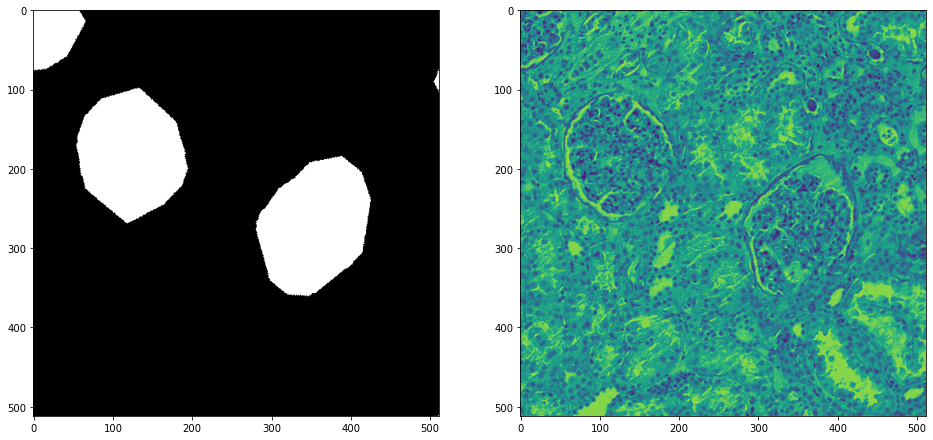

In [9]:
image, mask = ds[2]
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);

In [10]:
del image, mask
gc.collect()

4535

# B. Model

In [11]:
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DROPOUT = 0.5
POOLING = 'avg'


def get_model():
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        activation=ACTIVATION,
        in_channels=3,
        classes=1)
    # dropout=DROPOUT,
    # pooling=POOLING

    return model

In [12]:
def loss_fn(y_pred, y_true):
    bce = bce_loss(y_pred, y_true)
    dice = dice_loss(y_pred, y_true)
    return 0.4*bce + 0.6*dice

In [13]:
# Table for results
header = r'''
            Train     |     Valid
Epoch |  Loss |  Dice |  Loss |  Dice | Time, m
'''
#          Epoch         metrics              time
raw_line = '{:6d}' + '\u2502{:7.3f}'*4 + '\u2502{:6.2f}'

In [14]:
valid_idx, train_idx = [], []
for i in range(len(ds)):
    if ds.slices[i][0] == 7:
        valid_idx.append(i)
    else:
        train_idx.append(i)

In [15]:
def dice_metrics(output, target):
    mask1 = output.cpu().detach().numpy()
    mask2 = target.cpu().detach().numpy()
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3)  # for easy reading
    return dice

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth




            Train     |     Valid
Epoch |  Loss |  Dice |  Loss |  Dice | Time, m

     0│  0.498│  0.635│  0.356│  0.856│  2.04
Model saved!
     1│  0.354│  0.859│  0.349│  0.868│  2.00
Model saved!
     2│  0.342│  0.879│  0.333│  0.892│  2.01
Model saved!
     3│  0.337│  0.886│  0.369│  0.834│  2.00
     4│  0.338│  0.884│  0.339│  0.883│  1.99
     5│  0.334│  0.891│  0.330│  0.897│  2.00
Model saved!
     6│  0.332│  0.894│  0.343│  0.876│  2.01
     7│  0.333│  0.892│  0.337│  0.885│  2.00
     8│  0.334│  0.890│  0.335│  0.890│  2.00
     9│  0.339│  0.883│  0.340│  0.881│  2.01
    10│  0.333│  0.892│  0.332│  0.894│  2.01
    11│  0.332│  0.894│  0.330│  0.896│  2.00
    12│  0.328│  0.901│  0.332│  0.895│  2.00
    13│  0.332│  0.893│  0.349│  0.867│  2.01
    14│  0.334│  0.891│  0.443│  0.713│  2.00
    15│  0.331│  0.896│  0.340│  0.882│  2.01
    16│  0.330│  0.897│  0.337│  0.885│  2.01
    17│  0.328│  0.901│  0.331│  0.895│  2.01
    18│  0.328│  0.900│  0.330│  0.

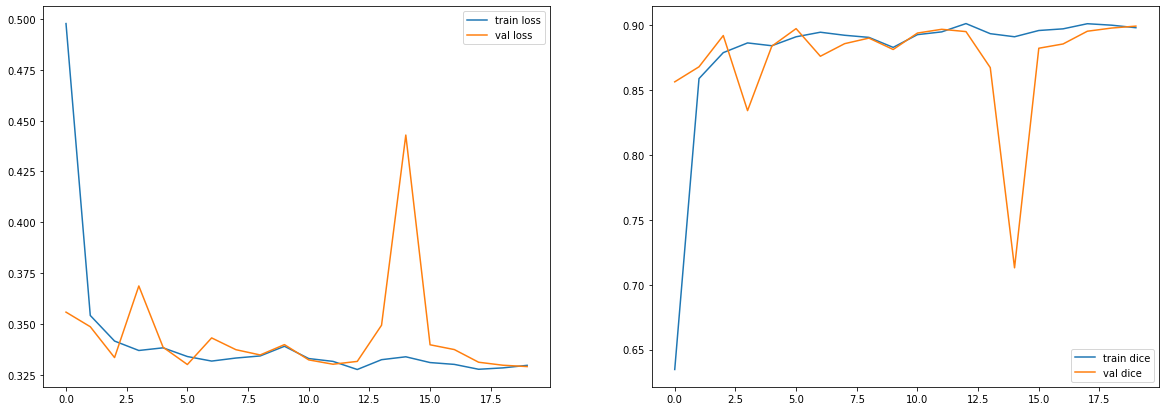


            Train     |     Valid
Epoch |  Loss |  Dice |  Loss |  Dice | Time, m

     0│  0.517│  0.604│  0.391│  0.802│  2.02
Model saved!
     1│  0.353│  0.861│  0.360│  0.850│  2.02
Model saved!
     2│  0.345│  0.874│  0.335│  0.888│  2.01
Model saved!
     3│  0.343│  0.877│  0.338│  0.883│  2.01
     4│  0.341│  0.880│  0.333│  0.891│  2.03
Model saved!
     5│  0.333│  0.893│  0.333│  0.892│  2.03
Model saved!
     6│  0.332│  0.894│  0.335│  0.889│  2.01
     7│  0.338│  0.885│  0.336│  0.887│  2.02
     8│  0.337│  0.886│  0.337│  0.885│  2.03
     9│  0.334│  0.891│  0.337│  0.885│  2.02
    10│  0.331│  0.896│  0.334│  0.889│  2.01
    11│  0.328│  0.901│  0.333│  0.892│  2.02
    12│  0.326│  0.904│  0.331│  0.894│  2.02
Model saved!
    13│  0.328│  0.901│  0.334│  0.890│  2.02
    14│  0.333│  0.893│  0.334│  0.890│  2.02
    15│  0.335│  0.890│  0.335│  0.889│  2.01
    16│  0.330│  0.897│  0.332│  0.893│  2.01
    17│  0.329│  0.899│  0.332│  0.893│  2.02
    18│  0

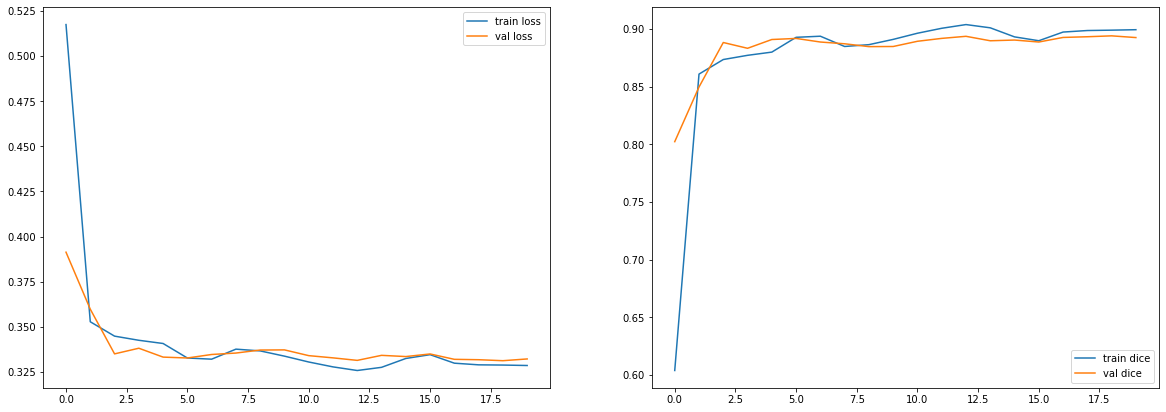


            Train     |     Valid
Epoch |  Loss |  Dice |  Loss |  Dice | Time, m

     0│  0.522│  0.599│  0.384│  0.814│  2.01
Model saved!
     1│  0.359│  0.851│  0.350│  0.865│  2.01
Model saved!
     2│  0.343│  0.876│  0.336│  0.887│  2.00
Model saved!
     3│  0.343│  0.876│  0.339│  0.883│  2.00
     4│  0.343│  0.877│  0.330│  0.897│  2.00
Model saved!
     5│  0.333│  0.892│  0.329│  0.898│  2.01
Model saved!
     6│  0.332│  0.894│  0.330│  0.898│  2.01
     7│  0.335│  0.889│  0.330│  0.897│  2.01
     8│  0.336│  0.888│  0.332│  0.893│  2.02
     9│  0.339│  0.883│  0.331│  0.895│  2.00
    10│  0.333│  0.893│  0.331│  0.896│  2.01
    11│  0.328│  0.899│  0.329│  0.899│  2.01
Model saved!
    12│  0.329│  0.899│  0.331│  0.896│  2.02
    13│  0.332│  0.894│  0.332│  0.894│  2.01
    14│  0.335│  0.889│  0.341│  0.879│  2.02
    15│  0.332│  0.894│  0.328│  0.900│  2.00
Model saved!
    16│  0.329│  0.898│  0.329│  0.898│  2.01
    17│  0.329│  0.898│  0.326│  0.903│  2.

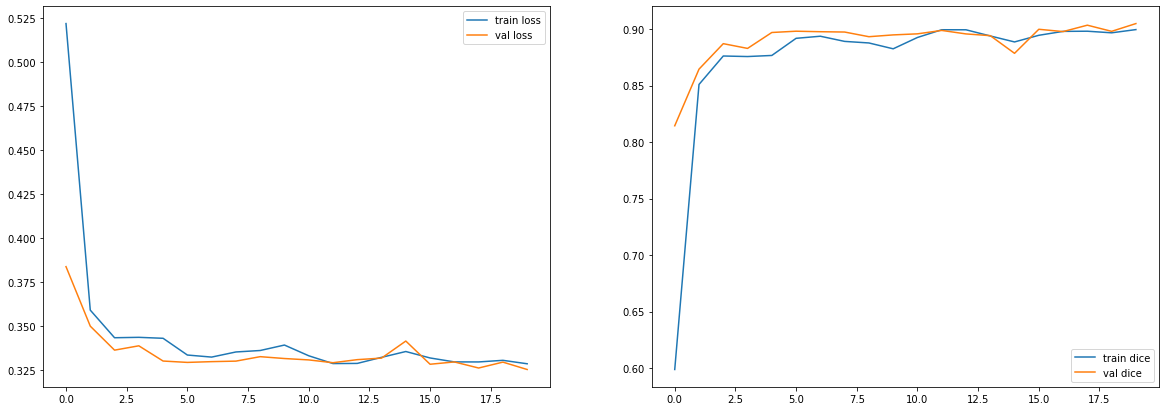


            Train     |     Valid
Epoch |  Loss |  Dice |  Loss |  Dice | Time, m

     0│  0.474│  0.675│  0.377│  0.824│  2.01
Model saved!
     1│  0.359│  0.851│  0.549│  0.571│  2.01
     2│  0.345│  0.872│  0.346│  0.873│  2.01
Model saved!
     3│  0.340│  0.881│  0.356│  0.855│  2.01
     4│  0.339│  0.882│  0.342│  0.878│  2.02
Model saved!
     5│  0.333│  0.891│  0.339│  0.884│  2.01
Model saved!
     6│  0.333│  0.893│  0.353│  0.865│  2.01
     7│  0.335│  0.888│  0.338│  0.885│  2.01
Model saved!
     8│  0.335│  0.889│  0.339│  0.884│  2.01
     9│  0.330│  0.896│  0.334│  0.892│  2.01
Model saved!
    10│  0.329│  0.898│  0.334│  0.892│  2.01
Model saved!
    11│  0.326│  0.903│  0.334│  0.892│  2.01
    12│  0.324│  0.906│  0.336│  0.888│  2.01
    13│  0.328│  0.900│  0.341│  0.881│  2.01
    14│  0.333│  0.891│  0.341│  0.881│  2.01
    15│  0.333│  0.892│  0.351│  0.865│  2.00
    16│  0.329│  0.898│  0.335│  0.890│  2.01
    17│  0.327│  0.902│  0.341│  0.881│  2.

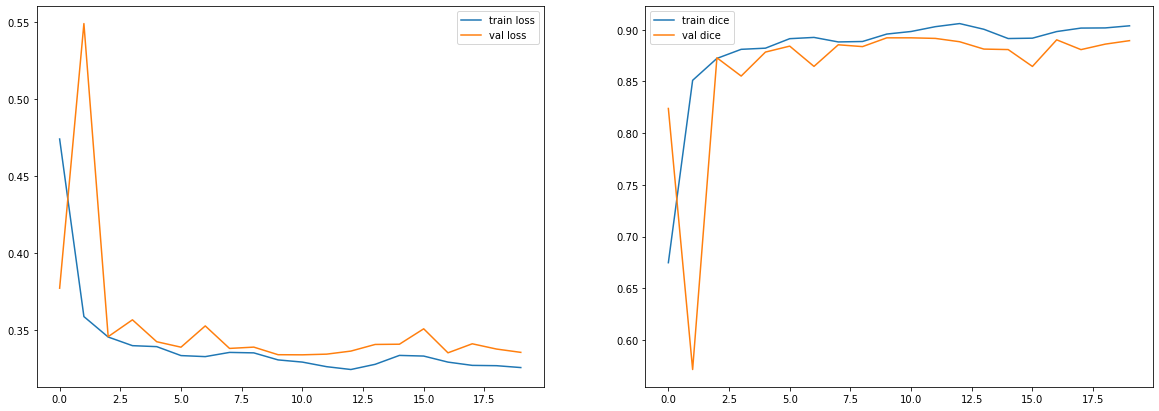

In [16]:
skf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(ds)):
    # dataset
    train_ds = D.Subset(ds, train_idx)
    valid_ds = D.Subset(ds, valid_idx)

    # dataloader
    train_loader = D.DataLoader(train_ds,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                pin_memory=True,
                                num_workers=NUM_WORKERS)
    val_loader = D.DataLoader(valid_ds,
                              batch_size=BATCH_SIZE,
                              shuffle=False, pin_memory=True,
                              num_workers=NUM_WORKERS)

    # model
    model = get_model()
    model.to(DEVICE)
    bce_loss = nn.BCEWithLogitsLoss()
    dice_loss = smp.utils.losses.DiceLoss()
    #optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
    optimizer = torch.optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=7, T_mult=2)

    # training
    best_loss = 5
    print(header)
    trains, vals = [], []
    trains_metric, vals_metric = [], []
    for epoch in range(EPOCHS):
        train_losses, val_losses = [], []
        train_dices, val_dices = [], []
        start_time = time.time()

        model.train()
        for image, target in train_loader:
            image, target = image.to(DEVICE), target.float().to(DEVICE)
            optimizer.zero_grad()
            output = model(image)
            loss = loss_fn(output, target)
            loss.backward()
            train_dices.append(dice_metrics(output, target))
            optimizer.step()
            scheduler.step()
            train_losses.append(loss.item())
        model.eval()

        with torch.no_grad():
            for image, target in val_loader:
                image, target = image.to(DEVICE), target.float().to(DEVICE)
                output = model(image)
                loss = loss_fn(output, target)
                val_losses.append(loss.item())
                val_dices.append(dice_metrics(output, target))

        train_loss = np.array(train_losses).mean()
        val_loss = np.array(val_losses).mean()
        train_dice = np.array(train_dices).mean()
        val_dice = np.array(val_dices).mean()
        trains.append(train_loss)
        vals.append(val_loss)
        trains_metric.append(train_dice)
        vals_metric.append(val_dice)
        print(raw_line.format(epoch,
                              train_loss,
                              train_dice,
                              val_loss,
                              val_dice,
                              (time.time()-start_time)/60**1))

        if best_loss > val_loss:
            best_loss = val_loss
            torch.save(model.state_dict(),
                       os.path.join(SAVE_DIR, f'best_model_{fold}.pth'))
            print('Model saved!')

    # plot
    plt.figure(figsize=(20, 7))
    plt.subplot(121)
    plt.plot(trains, label='train loss')
    plt.plot(vals, label='val loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(trains_metric, label='train dice')
    plt.plot(vals_metric, label='val dice')
    plt.legend()
    plt.show()

In [17]:
del ds, train_ds, valid_ds
del train_loader, val_loader, model
del trains, vals, trains_metric, vals_metric
del train_losses, val_losses, train_dices, val_dices
gc.collect()

11321